# **Part 1: Data Exploration and Cleaning**

#### This is a preliminary data exploration, which intends to load the datasets, identify issues with the data, as well as to remove data that could later introduce biases in the models. The specific actions taken are provided together with each step.

#### We focus on New York City yellow cab data from the months of March, June, and November in 2017. The datasource can be found [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The data dictionary describing all variables can be found [here](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf).

#### The final **objective** of this analysis is to generate a model that **predicts the tip amount** to the rider.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import io
# pip install pandas-profiling==2.8.0 # For a reproducible analysis
from pandas_profiling import ProfileReport
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-03.csv"
req = requests.get(url).content
df = pd.read_csv(io.StringIO(req.decode('utf-8')))
print(df.shape)

url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-06.csv"
req = requests.get(url).content
df = df.append(pd.read_csv(io.StringIO(req.decode('utf-8'))))
print(df.shape)

url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-11.csv"
req = requests.get(url).content
df = df.append(pd.read_csv(io.StringIO(req.decode('utf-8'))))
print(df.shape)

df.head()

(10294628, 17)
(19951621, 17)
(29236424, 17)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-03-09 21:30:11,2017-03-09 21:44:20,1,4.06,1,N,148,48,1,14.0,0.5,0.5,3.06,0.0,0.3,18.36
1,2,2017-03-09 21:47:00,2017-03-09 21:58:01,1,2.73,1,N,48,107,2,11.5,0.5,0.5,0.00,0.0,0.3,12.80
2,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.27,1,N,79,162,1,10.0,0.5,0.5,2.82,0.0,0.3,14.12
3,2,2017-03-09 22:16:05,2017-03-10 06:26:11,1,3.86,1,N,237,41,1,12.0,0.5,0.5,3.99,0.0,0.3,17.29
4,2,2017-03-31 06:31:53,2017-03-31 06:41:48,1,3.45,1,N,41,162,2,12.0,0.5,0.5,0.00,0.0,0.3,13.30


#### Open the data report following [this link](https://rcruzgar.github.io/taxi_tips/).

This report shows basic statistics, the histograms and the common and extreme values.

In [ ]:
profile = ProfileReport(df, minimal=True)
profile.to_file("index.html")

### **Conclusions from the report**:

* In principle, no missing values appear for none of the variables, but these could be masked with other values. So we will investigate it further for each column.

* **passenger_count**: There seem to be incoherent values: 0, 7, 8 and 9 passengers. All together represent less than 0.5% of the trips. As it is a driver-entered value, we will remove those trips. For 0 passengers it could actually be a service for transporting some object, but as these are exceptional cases, we remove that information.

In [ ]:
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 7)]

* **trip_distance**: The maximum value as reported by the taximeter is **9496.98 miles**, although there are other extreme values:

In [ ]:
df.sort_values(by=['trip_distance'], ascending=False).head(30)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
5640037,2,2017-06-20 15:21:21,2017-06-22 11:19:32,1,9496.98,1,N,193,193,2,9999.99,0.0,0.0,0.00,0.00,0.0,9999.99
5203847,2,2017-06-19 09:02:27,2017-06-20 15:20:43,1,6545.78,1,N,193,193,2,9999.99,0.0,0.0,0.00,0.00,0.0,9999.99
4201741,2,2017-06-16 11:47:32,2017-06-19 08:58:12,1,4942.40,1,N,193,193,2,9999.99,0.0,0.0,0.00,0.00,0.0,9999.99
9218988,2,2017-06-09 16:01:22,2017-06-10 09:48:14,1,4208.94,1,N,193,193,2,9999.99,0.0,0.0,0.00,0.00,0.0,9999.99
5632690,1,2017-06-28 09:14:26,2017-06-28 09:14:30,1,770.00,1,N,145,145,2,2.50,0.0,0.5,0.00,0.00,0.3,3.30
5556688,1,2017-06-28 08:50:36,2017-06-28 08:52:13,1,770.00,1,N,226,264,2,2.50,0.0,0.5,0.00,0.00,0.3,3.30
3527931,1,2017-06-14 14:20:34,2017-06-14 14:31:56,2,733.40,2,N,186,137,3,12837.45,0.0,53.8,0.00,0.00,0.0,12891.25
2477886,1,2017-11-08 17:26:12,2017-11-08 17:44:05,2,702.50,1,N,231,107,1,12.50,1.0,0.5,2.50,0.00,0.3,16.80
481809,1,2017-03-01 10:57:35,2017-03-01 11:18:15,1,598.50,1,N,246,230,1,14.50,0.0,0.5,3.05,0.00,0.3,18.35
3493783,1,2017-11-11 15:09:50,2017-11-11 22:47:49,4,396.30,5,N,265,265,2,400.00,0.0,0.0,0.00,10.76,0.3,411.06


We see non-sense values for the **total_amount** corresponding to large distances. For this reason and since these distances are extreme (the 95th percentile is 10.77 miles), we remove all trips larger than 249 miles. Also the trips with 0 miles.

In [ ]:
df = df[(df['trip_distance'] > 0) & (df['trip_distance'] < 249)]

* **RatecodeID**: In the dictionary values range from 1 to 6, but in the pandas profile-report there are RatecodeID with values of 99 (initially 524 times). Check if there remain some:

In [ ]:
print(df['RatecodeID'].unique())
df[df['RatecodeID'] == 99].shape[0]

[ 1  2  5  3  4  6 99]


8

Remove those 99.

In [ ]:
df = df[df['RatecodeID'] < 99]

* **store_and_fwd_flag**: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. **Y** = store and  forward trip. **N** = not a store and forward trip.

Although the Y flag is the minority class, nothing looks wrong with it.


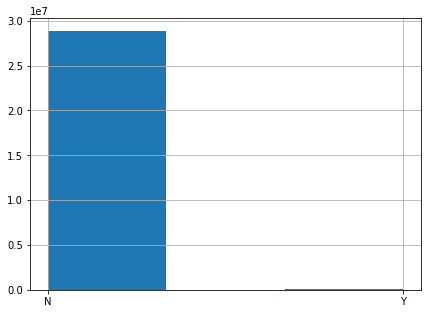

In [ ]:
df['store_and_fwd_flag'].hist(bins=3, figsize=(7,5))
plt.show()

Let's convert these flags into numbers in case we later use it as a predictor and to consider it in other possible analyses (such as the correlation heatmap). 1 for N and 0 for Y:

In [ ]:
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].apply(lambda row: 0 if row == "Y" else 1)

* **PULocationID** and **DOLocationID**: Taxi Zones in which the taximeter was turned on and turned off, correpondingly. Nothing wrong with this column. One question to test would be if there is a correlation between the zones where taximeter turns on/off and the tips. Maybe people from wealthy neighborhoods give more and larger tips.

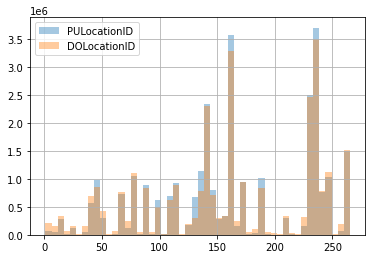

In [ ]:
df['PULocationID'].hist(bins=50, alpha=0.4)
df['DOLocationID'].hist(bins=50, alpha=0.4) 
labels= ["PULocationID","DOLocationID"]
plt.legend(labels)
plt.show()

* **payment_type**: As we will see with **tip_amount**, only credit card tips are automatically populated. The other payment types (no charge, dispute, unknown and voided trip) will also be removed.

In [ ]:
df = df[df['payment_type'] == 1]

Drop that column, which now has a unique value.

In [ ]:
df.drop(['payment_type'], axis=1, inplace=True)

* **fare_amount**: Initially there were negative values and zeros. Also very large values (the maximum before starting processing was 630461.82).

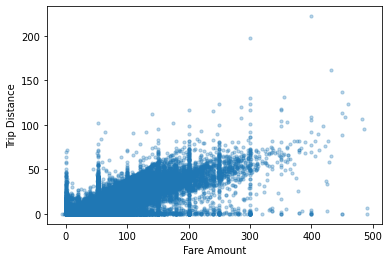

In [ ]:
plt.scatter(df['fare_amount'], df['trip_distance'], alpha = 0.3, s = 10)
plt.xlabel("Fare Amount")
plt.ylabel("Trip Distance")
plt.show()

In general there tend to be a linear relationship between the fare amount and the trip distance. Some high-fare trips with very short distances could be related to services in which the taxi driver was stopped for a long time, so we won't discard until checking the trip duration.

In [ ]:
df[(df['fare_amount'] > 300) & (df['trip_distance'] < 50)].shape[0]

47

There are still 552 rows with **fare_amount** less or equal to 0. As this amount is very small and it could be due to various errors, we remove them.

In [ ]:
print(df[df['fare_amount'] <= 0].shape[0])
df = df[df['fare_amount'] > 0]

552


* **extra**: It contains negative values.

  > 0: No extra charge.

  > 0.5 & 1: Rush hour and overnight extras.

  > Other: Miscellaneous? 

In [ ]:
df['extra'].value_counts()

 0.00     10108339
 0.50      6364545
 1.00      3182153
 4.50        80322
 0.02           24
 1.50           20
 0.30           14
 4.54           10
 2.00            4
 1.01            4
 6.52            4
 2.50            2
-0.50            2
 3.50            2
 0.70            2
 10.00           1
-42.50           1
 0.60            1
 6.00            1
 5.00            1
-0.49            1
 3.00            1
 0.75            1
 69.80           1
-6.60            1
 64.20           1
-38.60           1
-0.45            1
 0.95            1
-10.60           1
-12.60           1
 0.45            1
 1.30            1
 1.45            1
 0.80            1
Name: extra, dtype: int64

There are mostly 0, 0.5, 1 and 4.5. The 4.5 charge is not specified in the dictionary, but it has to be related to some constant extra, like extra luggage. We discard the rest and investigate the origin of 4.5 in the "Data Summary" notebook.

In [ ]:
df = df[(df['extra'] == 0) | (df['extra'] == 0.5) | (df['extra'] == 1) | (df['extra'] == 4.5)]

* **mta_tax**: It is supposed to be automatically 0.5, but there are other values, so we remove the rows with numbers different from 0.5 and 0 (0 because it has to be some error that should not affect the tips). We remove this column afterwards, since a constant will not provide predictive information in the model. 

In [ ]:
df['mta_tax'].value_counts()

0.50    19664654
0.00       70254
0.85         444
0.37           3
7.68           2
0.78           1
0.93           1
Name: mta_tax, dtype: int64

In [ ]:
df = df[(df['mta_tax'] == 0.5) | (df['mta_tax'] == 0)]

In [ ]:
df.drop(['mta_tax'], axis=1, inplace=True)

* **tolls_amount**: Everything looks normal for large **tolls_amount**, so we keep the values.

In [ ]:
df['tolls_amount'].describe()

count    1.973491e+07
mean     3.723149e-01
std      1.581132e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.124700e+02
Name: tolls_amount, dtype: float64

In [ ]:
df['tolls_amount'].value_counts()

0.00      18547473
5.76        864347
5.54        233293
10.50        18375
12.50        12479
            ...   
19.59            1
12.45            1
155.76           1
4.66             1
30.32            1
Name: tolls_amount, Length: 1481, dtype: int64

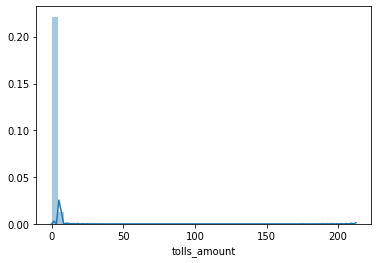

In [ ]:
ax = sns.distplot(df['tolls_amount'])

In [ ]:
df.loc[df['tolls_amount'] == 155.76]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount
6030055,1,2017-11-19 09:37:25,2017-11-19 10:17:00,1,16.2,1,1,138,45,48.0,0.0,36.82,155.76,0.3,241.38


* **improvement_surcharge**: It should be 0.3.

In [ ]:
df['improvement_surcharge'].value_counts()

0.3    19734688
0.0         220
Name: improvement_surcharge, dtype: int64

In [ ]:
df[df['improvement_surcharge'] == 0].head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount
290962,2,2017-03-11 04:13:10,2017-03-11 04:14:53,2,0.06,5,1,79,113,90.0,0.0,22.62,0.0,0.0,113.12
721725,2,2017-03-01 23:28:20,2017-03-01 23:28:20,2,0.01,5,1,264,170,60.0,0.0,12.00,0.0,0.0,72.00
1006649,2,2017-03-02 19:22:50,2017-03-02 19:44:50,1,4.00,1,1,264,90,17.0,1.0,0.00,0.0,0.0,18.50
1608956,2,2017-03-04 04:01:57,2017-03-04 04:45:37,1,6.30,1,1,255,107,22.5,0.5,0.00,0.0,0.0,23.50
1632551,2,2017-03-04 08:32:59,2017-03-04 08:50:34,1,0.05,5,1,138,184,35.0,0.0,7.00,0.0,0.0,42.00


We will try to find a relationship of those zero **improvement_surcharge** with other variables in the Data Summary notebook. If no relationship, this constant column will be dropped.




* **VendorID**: Everything looks correct. Either 1 or 2 values.

In [ ]:
df['VendorID'].describe()

count    1.973491e+07
mean     1.548858e+00
std      4.976072e-01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: VendorID, dtype: float64

* **tpep_pickup_datetime** and	**tpep_dropoff_datetime**: These are very important variables, since they will allow to investigate potential relationships once the trip times are calculated, as well as the information of the different days of the week and months. In principle, only March, June and November of 2017 have been loaded. First, reformat the dates, just in case.

In [ ]:
df['tpep_pickup_datetime'].describe()

count                19734908
unique                6449941
top       2017-11-05 01:12:35
freq                       20
Name: tpep_pickup_datetime, dtype: object

In [ ]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
df['tpep_pickup_datetime'].describe()

count                19734908
unique                6449941
top       2017-11-05 01:12:35
freq                       20
first     2008-12-31 10:51:28
last      2017-12-01 23:46:07
Name: tpep_pickup_datetime, dtype: object

In [ ]:
df['tpep_dropoff_datetime'].describe()

count                19734908
unique                6459161
top       2017-06-09 00:00:00
freq                       50
first     2008-12-31 11:23:28
last      2017-12-02 00:14:28
Name: tpep_dropoff_datetime, dtype: object

There seem to be dates including 2008 as the year. So let's be sure that there aren't more years / months / days out of our range.

In [ ]:
print(sorted(df['tpep_pickup_datetime'].dt.year.unique()))
print(sorted(df['tpep_dropoff_datetime'].dt.year.unique()))

[2008, 2009, 2017]
[2008, 2009, 2017]


In [ ]:
print(sorted(df['tpep_pickup_datetime'].dt.month.unique()))
print(sorted(df['tpep_dropoff_datetime'].dt.month.unique()))

[1, 3, 6, 10, 11, 12]
[1, 3, 4, 6, 7, 10, 11, 12]


In [ ]:
print(sorted(df['tpep_pickup_datetime'].dt.day.unique()))
print(sorted(df['tpep_dropoff_datetime'].dt.day.unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


We will remove the rows with ilogical years and months. 

First, how many "wrong" years there are, to check that there is no systematic error:

In [ ]:
df[(df['tpep_pickup_datetime'].dt.year == 2008) | (df['tpep_pickup_datetime'].dt.year == 2009) | (df['tpep_dropoff_datetime'].dt.year == 2008) | (df['tpep_dropoff_datetime'].dt.year == 2009)].shape[0]

15

Remove those years:

In [ ]:
df = df[(df['tpep_pickup_datetime'].dt.year == 2017) | (df['tpep_dropoff_datetime'].dt.year == 2017)]

For the months, note that we do not count April, July and December for the **tpep_dropoff_datetime**, since there could be trips starting close to midnight of the last days of the month:

In [ ]:
df[(df['tpep_pickup_datetime'].dt.month == 1) | (df['tpep_pickup_datetime'].dt.month == 10) | (df['tpep_pickup_datetime'].dt.month == 12) | (df['tpep_dropoff_datetime'].dt.month == 1) | (df['tpep_dropoff_datetime'].dt.month == 10)].shape[0]

215

Keep our 3 months (March, June, November) and the corresponding following ones (April, July, December):

In [ ]:
df = df[(df['tpep_pickup_datetime'].dt.month == 3) | (df['tpep_dropoff_datetime'].dt.month == 4) | (df['tpep_pickup_datetime'].dt.month == 6) | (df['tpep_dropoff_datetime'].dt.month == 7) | (df['tpep_pickup_datetime'].dt.month == 11) | (df['tpep_dropoff_datetime'].dt.month == 12)]

June 30th, 2017 was actually Friday, so there could be people going out at 23h and arriving after midnight, for example (2257 trips starting at 23h and finishing after midnight, indeed):

In [ ]:
df.loc[(df['tpep_pickup_datetime'].dt.year == 2017) & (df['tpep_pickup_datetime'].dt.month == 6) & (df['tpep_pickup_datetime'].dt.day == 30) & (df['tpep_pickup_datetime'].dt.hour == 23) & (df['tpep_dropoff_datetime'].dt.month == 7)].shape[0]

2257

**Calculate the trip duration in minutes**

In [ ]:
df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

In [ ]:
df['trip_time'].describe()

count    1.973476e+07
mean     1.721758e+01
std      5.392505e+01
min     -4.280283e+03
25%      7.150000e+00
50%      1.183333e+01
75%      1.933333e+01
max      1.440765e+04
Name: trip_time, dtype: float64

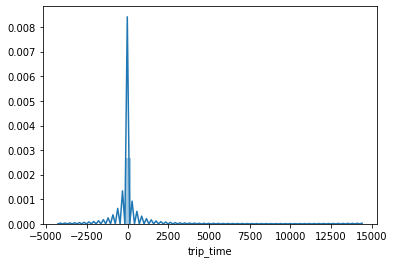

In [ ]:
sns.distplot(df['trip_time'])

In [ ]:
print('Nr of zeros:', df[df['trip_time'] == 0].shape[0])
print('Nr of lower than zero:', df[df['trip_time'] < 0].shape[0])
print('Nrs larger than 6h:', df[df['trip_time'] > 360].shape[0]) 

Nr of zeros: 524
Nr of lower than zero: 1025
Nrs larger than 6h: 28889


In [ ]:
df[df['trip_time'] < 0].tail(7)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time
1412692,1,2017-11-05 01:58:08,2017-11-05 01:08:39,1,2.7,1,1,68,13,10.5,0.5,2.35,0.0,0.3,14.15,-49.483333
1412698,1,2017-11-05 01:52:20,2017-11-05 01:01:57,4,1.6,1,1,249,231,8.5,0.5,1.95,0.0,0.3,11.75,-50.383333
1412722,1,2017-11-05 01:50:31,2017-11-05 01:23:23,2,7.1,1,1,162,33,26.5,0.5,5.55,0.0,0.3,33.35,-27.133333
1412740,1,2017-11-05 01:44:10,2017-11-05 01:06:07,1,1.8,1,1,107,148,14.5,0.5,1.00,0.0,0.3,16.80,-38.050000
1412749,1,2017-11-05 01:46:29,2017-11-05 01:02:02,1,1.2,1,1,79,232,10.5,0.5,3.50,0.0,0.3,15.30,-44.450000
1412785,1,2017-11-05 01:55:13,2017-11-05 01:02:30,1,1.1,1,1,68,246,7.0,0.5,1.65,0.0,0.3,9.95,-52.716667
1412871,1,2017-11-05 01:41:45,2017-11-05 01:03:47,4,3.5,1,1,231,170,16.0,0.0,1.50,0.0,0.3,18.30,-37.966667


Negative trip times appear on November 5th, which is actually when clocks go backward an hour at 2am to 3am. This presumably affects also on March 12th in the opposite sense. This could be corrected by adding/subtracting 1 h for the trip time and hours, but as we will reduce considerably the sample for the model (currently accounting for more than 19 million rows), there is no pain to remove them all.

The zero and negative values are not even the 0.01%.

In [ ]:
(df[df['trip_time'] == 0].shape[0] + df[df['trip_time'] < 0].shape[0])*100/ df.shape[0]

0.007849096682477182

In [ ]:
df = df[df['trip_time'] > 0]

Very large values corresponding to the equivalent of 24h might be related to an error, in which the pick-up and drop-off times are interchanged and close to midnight. Trips longer than 6 hours represent the 0.15%. It is already large enough as to consider it as exceptional, so we remove longer trips than 6h.

In [ ]:
(df[df['trip_time'] > 360].shape[0])*100/ df.shape[0]

0.14638641320857543

In [ ]:
df = df[df['trip_time'] < 360]

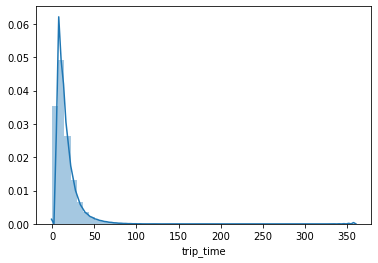

In [ ]:
sns.distplot(df['trip_time'])

* **tip_amount** and **total_amount**: For the tips we will be straightforward and remove the negative and extreme values to later dispose of a less skewed data set.

In [ ]:
df = df[df['tip_amount'] > 0]

In [ ]:
df = df[df['tip_amount'] < df['tip_amount'].quantile(0.9999)]

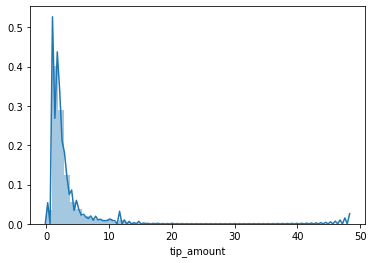

In [ ]:
sns.distplot(df['tip_amount'])

For the total amount, the same criteria will be used. We remove the 

In [ ]:
df['total_amount'].describe()

count    1.889668e+07
mean     1.776113e+01
std      1.451214e+01
min      6.900000e-01
25%      9.360000e+00
50%      1.296000e+01
75%      1.955000e+01
max      4.660600e+02
Name: total_amount, dtype: float64

In [ ]:
df = df[df['total_amount'] < df['total_amount'].quantile(0.9999)]

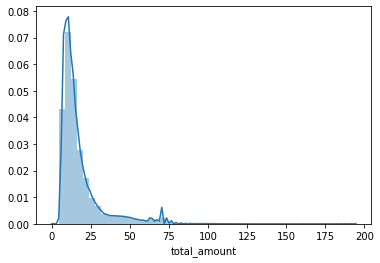

In [ ]:
sns.distplot(df['total_amount'])

In [ ]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18894786 entries, 0 to 9284802
Data columns (total 16 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   RatecodeID             int64         
 6   store_and_fwd_flag     int64         
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   fare_amount            float64       
 10  extra                  float64       
 11  tip_amount             float64       
 12  tolls_amount           float64       
 13  improvement_surcharge  float64       
 14  total_amount           float64       
 15  trip_time              float64       
dtypes: datetime64[ns](2), float64(8), int64(6)
memory usage: 2.4 GB


In [ ]:
df.to_csv('YellowTaxi_Mar-Jun-Nov2017.csv', index=False)

### Last thoughts:

In this first cleaning step, we have removed rows with corrupt values, outliers, and other suspicious information that could introduce biases in the future model. Some assumptions have been done, such as removing trips larger than 248 miles or keeping data with large tolls and long trip duration. The decission of removing some data has been taken because the dataset is big enough. On top of that, the training will probably be reduced to build the models faster. In other situations, with a smaller data set, more precaution and time could be taken.



---

